In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
# Define defect class mapping
defect_classes = {
    '1': 'punching_hole',
    '2': 'welding_line',
    '3': 'crescent_gap',
    '4': 'water_spot',
    '5': 'oil_spot',
    '6': 'silk_spot',
    '7': 'inclusion',
    '8': 'rolled_pit',
    '9': 'crease',
    '10': 'waist_folding'
}

In [3]:
import zipfile
import os

# List all files to find your zip
print("Files in current directory:")
all_files = os.listdir()
for f in all_files:
    print(f"  {f}")

# Find zip files
zip_files = [f for f in all_files if f.endswith('.zip')]
print(f"\nZip files found: {zip_files}")

# If you see your zip file in the list above, use its exact name
zip_filename = "archive (2).zip"

# Extract the zip file
if zip_filename in all_files:
    print(f"Extracting {zip_filename}...")
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall()

    # Remove zip file after extraction
    os.remove(zip_filename)
    print("Extraction complete!")

Files in current directory:
  .config
  archive (2).zip
  sample_data

Zip files found: ['archive (2).zip']
Extracting archive (2).zip...
Extraction complete!


In [4]:
# Search for your GC10-DET dataset across common locations
import os

def find_dataset(search_path='/'):
    """Search for GC10-DET dataset in the filesystem"""
    for root, dirs, files in os.walk(search_path):
        # Look for folders with numbered directories (1,2,3...10)
        numbered_dirs = [d for d in dirs if d.isdigit()]
        if len(numbered_dirs) >= 8:  # Should have folders 1-10
            print(f"Found potential dataset at: {root}")
            print(f"Contains folders: {sorted(numbered_dirs, key=lambda x: int(x))}")
            return root
    return None

# Search in current directory and subdirectories
dataset_path = find_dataset('.')
if dataset_path:
    data_path = dataset_path
    print(f"\n Dataset ready at: {data_path}")
else:
    print("Dataset not found in current location")


Found potential dataset at: .
Contains folders: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']

 Dataset ready at: .


In [5]:
import glob
from collections import Counter
# Create image dataset
image_data = []
label_counts = Counter()

for folder_num, defect_name in defect_classes.items():
    folder_path = os.path.join(data_path, folder_num)
    if os.path.exists(folder_path):
        images = glob.glob(os.path.join(folder_path, '*.jpg'))
        for img_path in images:
            image_data.append({
                'image_path': img_path,
                'label': defect_name,
                'class_id': int(folder_num) - 1  # 0-indexed for PyTorch
            })
        label_counts[defect_name] = len(images)

print(f"Total images: {len(image_data)}")
print("\nDefect distribution:")
for defect, count in label_counts.items():
    print(f"  {defect}: {count} images")

Total images: 2312

Defect distribution:
  punching_hole: 219 images
  welding_line: 273 images
  crescent_gap: 226 images
  water_spot: 289 images
  oil_spot: 204 images
  silk_spot: 651 images
  inclusion: 216 images
  rolled_pit: 31 images
  crease: 53 images
  waist_folding: 150 images


In [6]:
# Custom Dataset Class for Vision Transformers
class GC10DefectDataset(Dataset):
    def __init__(self, image_data, transform=None):
        self.image_data = image_data
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        item = self.image_data[idx]
        image = Image.open(item['image_path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, item['class_id']

In [7]:
# Vision Transformer transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Dataset class ready for Vision Transformer!")

Dataset class ready for Vision Transformer!


In [8]:
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import timm  # For pretrained Vision Transformers

# Vision Transformer for Manufacturing Defect Detection
class ManufacturingDefectViT(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ManufacturingDefectViT, self).__init__()

        # Load pretrained Vision Transformer
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained)

        # Replace classifier head for our 10 defect classes
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

        # Add dropout for regularization
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Forward pass through Vision Transformer
        x = self.vit(x)
        return x

# Create model instance
model = ManufacturingDefectViT(num_classes=10, pretrained=True).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [10]:
# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Vision Transformer Model Created")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Architecture: ViT-Base/16 with custom classification head")

Vision Transformer Model Created
Total parameters: 85,806,346
Trainable parameters: 85,806,346
Architecture: ViT-Base/16 with custom classification head


In [11]:
from sklearn.model_selection import train_test_split

# Split dataset into train/validation/test
train_data, temp_data = train_test_split(image_data, test_size=0.3,
                                        stratify=[item['class_id'] for item in image_data],
                                        random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5,
                                     stratify=[item['class_id'] for item in temp_data],
                                     random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

# Create datasets
train_dataset = GC10DefectDataset(train_data, transform=train_transform)
val_dataset = GC10DefectDataset(val_data, transform=val_transform)
test_dataset = GC10DefectDataset(test_data, transform=val_transform)

Training samples: 1618
Validation samples: 347
Test samples: 347


In [12]:
# Create dataloaders
batch_size = 16  # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders created with batch size: {batch_size}")

DataLoaders created with batch size: 16


In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy

# Validation function
def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy

print("Training functions ready")


Training functions ready


In [14]:
import time
from tqdm import tqdm

# Enhanced training function with progress tracking
def train_epoch_with_progress(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Progress bar for batches
    pbar = tqdm(train_loader, desc="Training")

    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Update progress bar every batch
        current_acc = 100. * correct / total
        current_loss = running_loss / (batch_idx + 1)
        pbar.set_postfix({
            'Loss': f'{current_loss:.4f}',
            'Acc': f'{current_acc:.2f}%'
        })

        # Print detailed progress every 10 batches
        if (batch_idx + 1) % 10 == 0:
            print(f"\n  Batch {batch_idx+1}/{len(train_loader)}: Loss={current_loss:.4f}, Acc={current_acc:.2f}%")

    final_acc = 100. * correct / total
    final_loss = running_loss / len(train_loader)
    return final_loss, final_acc

# Training loop with time tracking
print("Starting Vision Transformer training with FULL progress tracking...")

num_epochs = 20  # Reduced for faster completion
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()

    print(f"\n{'='*60}")
    print(f"EPOCH {epoch+1}/{num_epochs}")
    print(f"{'='*60}")

    # Training with progress
    train_loss, train_acc = train_epoch_with_progress(model, train_loader, criterion, optimizer, device)

    # Validation
    print("\nValidating...")
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Time tracking
    epoch_time = time.time() - epoch_start

    # Update scheduler
    scheduler.step()

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_vit_defect_model.pth')
        print("New best model saved!")

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Detailed epoch summary
    print(f"\n EPOCH {epoch+1} SUMMARY:")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"   Val Loss: {val_loss:.4f}   | Val Acc: {val_acc:.2f}%")
    print(f"   Time: {epoch_time:.1f}s")
    print(f"   Best Val Acc: {best_val_acc:.2f}%")

    # Estimated time remaining
    elapsed = time.time() - start_time
    avg_epoch_time = elapsed / (epoch + 1)
    remaining_epochs = num_epochs - (epoch + 1)
    eta = remaining_epochs * avg_epoch_time

    if remaining_epochs > 0:
        print(f"   ETA: {eta/60:.1f} minutes remaining")

total_time = time.time() - start_time
print(f"\n Training completed in {total_time/60:.1f} minutes!")
print(f" Best validation accuracy: {best_val_acc:.2f}%")


Starting Vision Transformer training with FULL progress tracking...

EPOCH 1/20


Training:  10%|▉         | 10/102 [00:10<01:18,  1.17it/s, Loss=2.4453, Acc=20.62%]


  Batch 10/102: Loss=2.4453, Acc=20.62%


Training:  20%|█▉        | 20/102 [00:18<01:13,  1.12it/s, Loss=2.1944, Acc=27.19%]


  Batch 20/102: Loss=2.1944, Acc=27.19%


Training:  29%|██▉       | 30/102 [00:28<01:11,  1.00it/s, Loss=1.9255, Acc=35.42%]


  Batch 30/102: Loss=1.9255, Acc=35.42%


Training:  39%|███▉      | 40/102 [00:36<00:52,  1.19it/s, Loss=1.7484, Acc=41.72%]


  Batch 40/102: Loss=1.7484, Acc=41.72%


Training:  49%|████▉     | 50/102 [00:45<00:44,  1.17it/s, Loss=1.6284, Acc=46.00%]


  Batch 50/102: Loss=1.6284, Acc=46.00%


Training:  59%|█████▉    | 60/102 [00:56<00:45,  1.08s/it, Loss=1.5361, Acc=49.79%]


  Batch 60/102: Loss=1.5361, Acc=49.79%


Training:  69%|██████▊   | 70/102 [01:05<00:31,  1.03it/s, Loss=1.5053, Acc=51.88%]


  Batch 70/102: Loss=1.5053, Acc=51.88%


Training:  78%|███████▊  | 80/102 [01:14<00:18,  1.17it/s, Loss=1.4612, Acc=53.59%]


  Batch 80/102: Loss=1.4612, Acc=53.59%


Training:  88%|████████▊ | 90/102 [01:22<00:10,  1.17it/s, Loss=1.3998, Acc=55.14%]


  Batch 90/102: Loss=1.3998, Acc=55.14%


Training:  98%|█████████▊| 100/102 [01:33<00:01,  1.05it/s, Loss=1.3665, Acc=55.44%]


  Batch 100/102: Loss=1.3665, Acc=55.44%


Training: 100%|██████████| 102/102 [01:34<00:00,  1.08it/s, Loss=1.3544, Acc=55.75%]



Validating...
New best model saved!

 EPOCH 1 SUMMARY:
   Train Loss: 1.3544 | Train Acc: 55.75%
   Val Loss: 0.7872   | Val Acc: 74.35%
   Time: 105.3s
   Best Val Acc: 74.35%
   ETA: 34.0 minutes remaining

EPOCH 2/20


Training:  10%|▉         | 10/102 [00:09<01:24,  1.09it/s, Loss=0.6918, Acc=76.25%]


  Batch 10/102: Loss=0.6918, Acc=76.25%


Training:  20%|█▉        | 20/102 [00:17<01:10,  1.17it/s, Loss=0.8449, Acc=72.50%]


  Batch 20/102: Loss=0.8449, Acc=72.50%


Training:  29%|██▉       | 30/102 [00:26<01:01,  1.16it/s, Loss=0.8548, Acc=70.62%]


  Batch 30/102: Loss=0.8548, Acc=70.62%


Training:  39%|███▉      | 40/102 [00:35<00:55,  1.12it/s, Loss=0.8669, Acc=70.00%]


  Batch 40/102: Loss=0.8669, Acc=70.00%


Training:  49%|████▉     | 50/102 [00:44<00:50,  1.03it/s, Loss=0.8739, Acc=70.12%]


  Batch 50/102: Loss=0.8739, Acc=70.12%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.16it/s, Loss=0.8839, Acc=69.06%]


  Batch 60/102: Loss=0.8839, Acc=69.06%


Training:  69%|██████▊   | 70/102 [01:02<00:27,  1.15it/s, Loss=0.8811, Acc=69.38%]


  Batch 70/102: Loss=0.8811, Acc=69.38%


Training:  78%|███████▊  | 80/102 [01:11<00:19,  1.11it/s, Loss=0.8670, Acc=70.00%]


  Batch 80/102: Loss=0.8670, Acc=70.00%


Training:  88%|████████▊ | 90/102 [01:20<00:11,  1.06it/s, Loss=0.8722, Acc=70.00%]


  Batch 90/102: Loss=0.8722, Acc=70.00%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.16it/s, Loss=0.8717, Acc=70.31%]


  Batch 100/102: Loss=0.8717, Acc=70.31%


Training: 100%|██████████| 102/102 [01:30<00:00,  1.13it/s, Loss=0.8715, Acc=70.21%]



Validating...

 EPOCH 2 SUMMARY:
   Train Loss: 0.8715 | Train Acc: 70.21%
   Val Loss: 0.9531   | Val Acc: 63.40%
   Time: 101.3s
   Best Val Acc: 74.35%
   ETA: 31.3 minutes remaining

EPOCH 3/20


Training:  10%|▉         | 10/102 [00:09<01:20,  1.14it/s, Loss=0.9315, Acc=70.00%]


  Batch 10/102: Loss=0.9315, Acc=70.00%


Training:  20%|█▉        | 20/102 [00:18<01:15,  1.09it/s, Loss=0.8819, Acc=70.62%]


  Batch 20/102: Loss=0.8819, Acc=70.62%


Training:  29%|██▉       | 30/102 [00:26<01:02,  1.16it/s, Loss=0.8493, Acc=69.17%]


  Batch 30/102: Loss=0.8493, Acc=69.17%


Training:  39%|███▉      | 40/102 [00:35<00:53,  1.15it/s, Loss=0.8121, Acc=70.31%]


  Batch 40/102: Loss=0.8121, Acc=70.31%


Training:  49%|████▉     | 50/102 [00:44<00:46,  1.12it/s, Loss=0.7658, Acc=72.38%]


  Batch 50/102: Loss=0.7658, Acc=72.38%


Training:  59%|█████▉    | 60/102 [00:54<00:39,  1.06it/s, Loss=0.7529, Acc=73.23%]


  Batch 60/102: Loss=0.7529, Acc=73.23%


Training:  69%|██████▊   | 70/102 [01:02<00:27,  1.16it/s, Loss=0.7568, Acc=73.30%]


  Batch 70/102: Loss=0.7568, Acc=73.30%


Training:  78%|███████▊  | 80/102 [01:11<00:19,  1.15it/s, Loss=0.7382, Acc=73.83%]


  Batch 80/102: Loss=0.7382, Acc=73.83%


Training:  88%|████████▊ | 90/102 [01:20<00:10,  1.12it/s, Loss=0.7218, Acc=74.65%]


  Batch 90/102: Loss=0.7218, Acc=74.65%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.02it/s, Loss=0.7125, Acc=74.75%]


  Batch 100/102: Loss=0.7125, Acc=74.75%


Training: 100%|██████████| 102/102 [01:30<00:00,  1.12it/s, Loss=0.7049, Acc=74.85%]



Validating...
New best model saved!

 EPOCH 3 SUMMARY:
   Train Loss: 0.7049 | Train Acc: 74.85%
   Val Loss: 0.4949   | Val Acc: 79.54%
   Time: 102.2s
   Best Val Acc: 79.54%
   ETA: 29.4 minutes remaining

EPOCH 4/20


Training:  10%|▉         | 10/102 [00:08<01:19,  1.16it/s, Loss=0.7299, Acc=76.25%]


  Batch 10/102: Loss=0.7299, Acc=76.25%


Training:  20%|█▉        | 20/102 [00:17<01:11,  1.15it/s, Loss=0.6415, Acc=78.75%]


  Batch 20/102: Loss=0.6415, Acc=78.75%


Training:  29%|██▉       | 30/102 [00:26<01:04,  1.12it/s, Loss=0.6263, Acc=79.58%]


  Batch 30/102: Loss=0.6263, Acc=79.58%


Training:  39%|███▉      | 40/102 [00:35<01:00,  1.03it/s, Loss=0.5891, Acc=80.00%]


  Batch 40/102: Loss=0.5891, Acc=80.00%


Training:  49%|████▉     | 50/102 [00:44<00:45,  1.15it/s, Loss=0.5953, Acc=79.62%]


  Batch 50/102: Loss=0.5953, Acc=79.62%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.15it/s, Loss=0.6127, Acc=79.17%]


  Batch 60/102: Loss=0.6127, Acc=79.17%


Training:  69%|██████▊   | 70/102 [01:02<00:29,  1.10it/s, Loss=0.6050, Acc=79.55%]


  Batch 70/102: Loss=0.6050, Acc=79.55%


Training:  78%|███████▊  | 80/102 [01:11<00:21,  1.04it/s, Loss=0.6042, Acc=79.30%]


  Batch 80/102: Loss=0.6042, Acc=79.30%


Training:  88%|████████▊ | 90/102 [01:20<00:10,  1.15it/s, Loss=0.6060, Acc=78.75%]


  Batch 90/102: Loss=0.6060, Acc=78.75%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.14it/s, Loss=0.6334, Acc=77.94%]


  Batch 100/102: Loss=0.6334, Acc=77.94%


Training: 100%|██████████| 102/102 [01:30<00:00,  1.12it/s, Loss=0.6273, Acc=78.12%]



Validating...
New best model saved!

 EPOCH 4 SUMMARY:
   Train Loss: 0.6273 | Train Acc: 78.12%
   Val Loss: 0.5707   | Val Acc: 81.84%
   Time: 102.0s
   Best Val Acc: 81.84%
   ETA: 27.8 minutes remaining

EPOCH 5/20


Training:  10%|▉         | 10/102 [00:09<01:20,  1.15it/s, Loss=0.5739, Acc=77.50%]


  Batch 10/102: Loss=0.5739, Acc=77.50%


Training:  20%|█▉        | 20/102 [00:18<01:13,  1.12it/s, Loss=0.6098, Acc=76.88%]


  Batch 20/102: Loss=0.6098, Acc=76.88%


Training:  29%|██▉       | 30/102 [00:27<01:10,  1.02it/s, Loss=0.6275, Acc=77.08%]


  Batch 30/102: Loss=0.6275, Acc=77.08%


Training:  39%|███▉      | 40/102 [00:35<00:53,  1.15it/s, Loss=0.6372, Acc=76.25%]


  Batch 40/102: Loss=0.6372, Acc=76.25%


Training:  49%|████▉     | 50/102 [00:45<00:45,  1.14it/s, Loss=0.6338, Acc=77.00%]


  Batch 50/102: Loss=0.6338, Acc=77.00%


Training:  59%|█████▉    | 60/102 [00:54<00:38,  1.10it/s, Loss=0.6108, Acc=77.60%]


  Batch 60/102: Loss=0.6108, Acc=77.60%


Training:  69%|██████▊   | 70/102 [01:03<00:30,  1.06it/s, Loss=0.6064, Acc=77.95%]


  Batch 70/102: Loss=0.6064, Acc=77.95%


Training:  78%|███████▊  | 80/102 [01:11<00:19,  1.15it/s, Loss=0.6186, Acc=77.19%]


  Batch 80/102: Loss=0.6186, Acc=77.19%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.13it/s, Loss=0.6234, Acc=77.50%]


  Batch 90/102: Loss=0.6234, Acc=77.50%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.08it/s, Loss=0.6267, Acc=77.69%]


  Batch 100/102: Loss=0.6267, Acc=77.69%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.6283, Acc=77.75%]



Validating...

 EPOCH 5 SUMMARY:
   Train Loss: 0.6283 | Train Acc: 77.75%
   Val Loss: 0.5599   | Val Acc: 79.54%
   Time: 102.4s
   Best Val Acc: 81.84%
   ETA: 26.0 minutes remaining

EPOCH 6/20


Training:  10%|▉         | 10/102 [00:08<01:20,  1.14it/s, Loss=0.8399, Acc=66.88%]


  Batch 10/102: Loss=0.8399, Acc=66.88%


Training:  20%|█▉        | 20/102 [00:17<01:11,  1.15it/s, Loss=0.6943, Acc=71.56%]


  Batch 20/102: Loss=0.6943, Acc=71.56%


Training:  29%|██▉       | 30/102 [00:26<01:03,  1.13it/s, Loss=0.6166, Acc=75.42%]


  Batch 30/102: Loss=0.6166, Acc=75.42%


Training:  39%|███▉      | 40/102 [00:35<00:58,  1.06it/s, Loss=0.6306, Acc=76.09%]


  Batch 40/102: Loss=0.6306, Acc=76.09%


Training:  49%|████▉     | 50/102 [00:44<00:45,  1.15it/s, Loss=0.6392, Acc=76.38%]


  Batch 50/102: Loss=0.6392, Acc=76.38%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.15it/s, Loss=0.6242, Acc=77.08%]


  Batch 60/102: Loss=0.6242, Acc=77.08%


Training:  69%|██████▊   | 70/102 [01:02<00:28,  1.12it/s, Loss=0.6381, Acc=76.61%]


  Batch 70/102: Loss=0.6381, Acc=76.61%


Training:  78%|███████▊  | 80/102 [01:12<00:21,  1.03it/s, Loss=0.6471, Acc=75.86%]


  Batch 80/102: Loss=0.6471, Acc=75.86%


Training:  88%|████████▊ | 90/102 [01:20<00:10,  1.15it/s, Loss=0.6435, Acc=76.25%]


  Batch 90/102: Loss=0.6435, Acc=76.25%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.15it/s, Loss=0.6356, Acc=76.38%]


  Batch 100/102: Loss=0.6356, Acc=76.38%


Training: 100%|██████████| 102/102 [01:30<00:00,  1.12it/s, Loss=0.6274, Acc=76.58%]



Validating...

 EPOCH 6 SUMMARY:
   Train Loss: 0.6274 | Train Acc: 76.58%
   Val Loss: 0.5600   | Val Acc: 78.67%
   Time: 102.0s
   Best Val Acc: 81.84%
   ETA: 24.2 minutes remaining

EPOCH 7/20


Training:  10%|▉         | 10/102 [00:09<01:23,  1.10it/s, Loss=0.8528, Acc=78.75%]


  Batch 10/102: Loss=0.8528, Acc=78.75%


Training:  20%|█▉        | 20/102 [00:18<01:20,  1.02it/s, Loss=0.7620, Acc=77.19%]


  Batch 20/102: Loss=0.7620, Acc=77.19%


Training:  29%|██▉       | 30/102 [00:26<01:03,  1.14it/s, Loss=0.6861, Acc=78.75%]


  Batch 30/102: Loss=0.6861, Acc=78.75%


Training:  39%|███▉      | 40/102 [00:36<00:54,  1.13it/s, Loss=0.6125, Acc=80.47%]


  Batch 40/102: Loss=0.6125, Acc=80.47%


Training:  49%|████▉     | 50/102 [00:45<00:47,  1.09it/s, Loss=0.5895, Acc=79.75%]


  Batch 50/102: Loss=0.5895, Acc=79.75%


Training:  59%|█████▉    | 60/102 [00:54<00:39,  1.06it/s, Loss=0.5930, Acc=79.48%]


  Batch 60/102: Loss=0.5930, Acc=79.48%


Training:  69%|██████▊   | 70/102 [01:02<00:27,  1.15it/s, Loss=0.5993, Acc=79.38%]


  Batch 70/102: Loss=0.5993, Acc=79.38%


Training:  78%|███████▊  | 80/102 [01:12<00:19,  1.13it/s, Loss=0.5688, Acc=80.86%]


  Batch 80/102: Loss=0.5688, Acc=80.86%


Training:  88%|████████▊ | 90/102 [01:21<00:11,  1.08it/s, Loss=0.5637, Acc=81.04%]


  Batch 90/102: Loss=0.5637, Acc=81.04%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.13it/s, Loss=0.5642, Acc=80.88%]


  Batch 100/102: Loss=0.5642, Acc=80.88%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.5595, Acc=80.78%]



Validating...
New best model saved!

 EPOCH 7 SUMMARY:
   Train Loss: 0.5595 | Train Acc: 80.78%
   Val Loss: 0.4579   | Val Acc: 83.57%
   Time: 102.1s
   Best Val Acc: 83.57%
   ETA: 22.4 minutes remaining

EPOCH 8/20


Training:  10%|▉         | 10/102 [00:08<01:19,  1.15it/s, Loss=0.3434, Acc=90.62%]


  Batch 10/102: Loss=0.3434, Acc=90.62%


Training:  20%|█▉        | 20/102 [00:18<01:12,  1.13it/s, Loss=0.4212, Acc=86.56%]


  Batch 20/102: Loss=0.4212, Acc=86.56%


Training:  29%|██▉       | 30/102 [00:27<01:06,  1.08it/s, Loss=0.4746, Acc=83.54%]


  Batch 30/102: Loss=0.4746, Acc=83.54%


Training:  39%|███▉      | 40/102 [00:35<00:54,  1.14it/s, Loss=0.5022, Acc=83.12%]


  Batch 40/102: Loss=0.5022, Acc=83.12%


Training:  49%|████▉     | 50/102 [00:45<00:45,  1.14it/s, Loss=0.5146, Acc=82.88%]


  Batch 50/102: Loss=0.5146, Acc=82.88%


Training:  59%|█████▉    | 60/102 [00:54<00:37,  1.13it/s, Loss=0.5094, Acc=82.71%]


  Batch 60/102: Loss=0.5094, Acc=82.71%


Training:  69%|██████▊   | 70/102 [01:03<00:30,  1.07it/s, Loss=0.5008, Acc=83.04%]


  Batch 70/102: Loss=0.5008, Acc=83.04%


Training:  78%|███████▊  | 80/102 [01:11<00:19,  1.15it/s, Loss=0.5011, Acc=82.73%]


  Batch 80/102: Loss=0.5011, Acc=82.73%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.14it/s, Loss=0.4931, Acc=83.06%]


  Batch 90/102: Loss=0.4931, Acc=83.06%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.12it/s, Loss=0.4944, Acc=82.88%]


  Batch 100/102: Loss=0.4944, Acc=82.88%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.5036, Acc=82.82%]



Validating...

 EPOCH 8 SUMMARY:
   Train Loss: 0.5036 | Train Acc: 82.82%
   Val Loss: 0.4656   | Val Acc: 81.27%
   Time: 102.6s
   Best Val Acc: 83.57%
   ETA: 20.7 minutes remaining

EPOCH 9/20


Training:  10%|▉         | 10/102 [00:09<01:29,  1.03it/s, Loss=0.5448, Acc=81.88%]


  Batch 10/102: Loss=0.5448, Acc=81.88%


Training:  20%|█▉        | 20/102 [00:17<01:11,  1.15it/s, Loss=0.4926, Acc=84.38%]


  Batch 20/102: Loss=0.4926, Acc=84.38%


Training:  29%|██▉       | 30/102 [00:26<01:03,  1.14it/s, Loss=0.4630, Acc=85.21%]


  Batch 30/102: Loss=0.4630, Acc=85.21%


Training:  39%|███▉      | 40/102 [00:36<00:56,  1.10it/s, Loss=0.5063, Acc=83.59%]


  Batch 40/102: Loss=0.5063, Acc=83.59%


Training:  49%|████▉     | 50/102 [00:45<00:51,  1.01it/s, Loss=0.5240, Acc=82.00%]


  Batch 50/102: Loss=0.5240, Acc=82.00%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.15it/s, Loss=0.5278, Acc=81.88%]


  Batch 60/102: Loss=0.5278, Acc=81.88%


Training:  69%|██████▊   | 70/102 [01:03<00:28,  1.14it/s, Loss=0.5234, Acc=81.96%]


  Batch 70/102: Loss=0.5234, Acc=81.96%


Training:  78%|███████▊  | 80/102 [01:12<00:19,  1.10it/s, Loss=0.5325, Acc=81.88%]


  Batch 80/102: Loss=0.5325, Acc=81.88%


Training:  88%|████████▊ | 90/102 [01:21<00:11,  1.07it/s, Loss=0.5318, Acc=81.94%]


  Batch 90/102: Loss=0.5318, Acc=81.94%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.15it/s, Loss=0.5238, Acc=82.06%]


  Batch 100/102: Loss=0.5238, Acc=82.06%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.5421, Acc=81.89%]



Validating...

 EPOCH 9 SUMMARY:
   Train Loss: 0.5421 | Train Acc: 81.89%
   Val Loss: 0.6900   | Val Acc: 74.93%
   Time: 102.2s
   Best Val Acc: 83.57%
   ETA: 18.9 minutes remaining

EPOCH 10/20


Training:  10%|▉         | 10/102 [00:09<01:20,  1.14it/s, Loss=0.7950, Acc=80.62%]


  Batch 10/102: Loss=0.7950, Acc=80.62%


Training:  20%|█▉        | 20/102 [00:18<01:15,  1.09it/s, Loss=0.7941, Acc=75.00%]


  Batch 20/102: Loss=0.7941, Acc=75.00%


Training:  29%|██▉       | 30/102 [00:26<01:03,  1.14it/s, Loss=0.7248, Acc=76.88%]


  Batch 30/102: Loss=0.7248, Acc=76.88%


Training:  39%|███▉      | 40/102 [00:35<00:53,  1.15it/s, Loss=0.6951, Acc=77.19%]


  Batch 40/102: Loss=0.6951, Acc=77.19%


Training:  49%|████▉     | 50/102 [00:45<00:45,  1.13it/s, Loss=0.6871, Acc=76.88%]


  Batch 50/102: Loss=0.6871, Acc=76.88%


Training:  59%|█████▉    | 60/102 [00:54<00:39,  1.05it/s, Loss=0.6642, Acc=77.60%]


  Batch 60/102: Loss=0.6642, Acc=77.60%


Training:  69%|██████▊   | 70/102 [01:02<00:27,  1.15it/s, Loss=0.6562, Acc=77.41%]


  Batch 70/102: Loss=0.6562, Acc=77.41%


Training:  78%|███████▊  | 80/102 [01:12<00:19,  1.14it/s, Loss=0.6604, Acc=76.80%]


  Batch 80/102: Loss=0.6604, Acc=76.80%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.11it/s, Loss=0.6381, Acc=77.71%]


  Batch 90/102: Loss=0.6381, Acc=77.71%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.04it/s, Loss=0.6241, Acc=78.56%]


  Batch 100/102: Loss=0.6241, Acc=78.56%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.6207, Acc=78.49%]



Validating...

 EPOCH 10 SUMMARY:
   Train Loss: 0.6207 | Train Acc: 78.49%
   Val Loss: 0.5187   | Val Acc: 82.13%
   Time: 102.6s
   Best Val Acc: 83.57%
   ETA: 17.2 minutes remaining

EPOCH 11/20


Training:  10%|▉         | 10/102 [00:08<01:19,  1.16it/s, Loss=0.3505, Acc=86.25%]


  Batch 10/102: Loss=0.3505, Acc=86.25%


Training:  20%|█▉        | 20/102 [00:17<01:12,  1.14it/s, Loss=0.3628, Acc=87.19%]


  Batch 20/102: Loss=0.3628, Acc=87.19%


Training:  29%|██▉       | 30/102 [00:26<01:04,  1.11it/s, Loss=0.3696, Acc=86.46%]


  Batch 30/102: Loss=0.3696, Acc=86.46%


Training:  39%|███▉      | 40/102 [00:36<01:00,  1.02it/s, Loss=0.3594, Acc=87.50%]


  Batch 40/102: Loss=0.3594, Acc=87.50%


Training:  49%|████▉     | 50/102 [00:44<00:45,  1.14it/s, Loss=0.3432, Acc=88.00%]


  Batch 50/102: Loss=0.3432, Acc=88.00%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.14it/s, Loss=0.3288, Acc=88.75%]


  Batch 60/102: Loss=0.3288, Acc=88.75%


Training:  69%|██████▊   | 70/102 [01:02<00:28,  1.10it/s, Loss=0.3292, Acc=88.48%]


  Batch 70/102: Loss=0.3292, Acc=88.48%


Training:  78%|███████▊  | 80/102 [01:11<00:20,  1.06it/s, Loss=0.3158, Acc=88.98%]


  Batch 80/102: Loss=0.3158, Acc=88.98%


Training:  88%|████████▊ | 90/102 [01:20<00:10,  1.15it/s, Loss=0.3092, Acc=89.31%]


  Batch 90/102: Loss=0.3092, Acc=89.31%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.13it/s, Loss=0.2982, Acc=89.62%]


  Batch 100/102: Loss=0.2982, Acc=89.62%


Training: 100%|██████████| 102/102 [01:30<00:00,  1.12it/s, Loss=0.3031, Acc=89.56%]



Validating...
New best model saved!

 EPOCH 11 SUMMARY:
   Train Loss: 0.3031 | Train Acc: 89.56%
   Val Loss: 0.3945   | Val Acc: 86.46%
   Time: 102.2s
   Best Val Acc: 86.46%
   ETA: 15.5 minutes remaining

EPOCH 12/20


Training:  10%|▉         | 10/102 [00:09<01:20,  1.14it/s, Loss=0.3056, Acc=87.50%]


  Batch 10/102: Loss=0.3056, Acc=87.50%


Training:  20%|█▉        | 20/102 [00:18<01:15,  1.09it/s, Loss=0.2705, Acc=89.69%]


  Batch 20/102: Loss=0.2705, Acc=89.69%


Training:  29%|██▉       | 30/102 [00:27<01:07,  1.07it/s, Loss=0.2754, Acc=89.38%]


  Batch 30/102: Loss=0.2754, Acc=89.38%


Training:  39%|███▉      | 40/102 [00:36<00:53,  1.16it/s, Loss=0.2721, Acc=89.06%]


  Batch 40/102: Loss=0.2721, Acc=89.06%


Training:  49%|████▉     | 50/102 [00:45<00:46,  1.12it/s, Loss=0.2526, Acc=89.75%]


  Batch 50/102: Loss=0.2526, Acc=89.75%


Training:  59%|█████▉    | 60/102 [00:54<00:38,  1.08it/s, Loss=0.2480, Acc=90.31%]


  Batch 60/102: Loss=0.2480, Acc=90.31%


Training:  69%|██████▊   | 70/102 [01:02<00:27,  1.16it/s, Loss=0.2458, Acc=90.36%]


  Batch 70/102: Loss=0.2458, Acc=90.36%


Training:  78%|███████▊  | 80/102 [01:12<00:19,  1.14it/s, Loss=0.2444, Acc=90.78%]


  Batch 80/102: Loss=0.2444, Acc=90.78%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.13it/s, Loss=0.2386, Acc=90.97%]


  Batch 90/102: Loss=0.2386, Acc=90.97%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.05it/s, Loss=0.2363, Acc=90.94%]


  Batch 100/102: Loss=0.2363, Acc=90.94%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.2368, Acc=90.91%]



Validating...

 EPOCH 12 SUMMARY:
   Train Loss: 0.2368 | Train Acc: 90.91%
   Val Loss: 0.3976   | Val Acc: 85.88%
   Time: 102.7s
   Best Val Acc: 86.46%
   ETA: 13.8 minutes remaining

EPOCH 13/20


Training:  10%|▉         | 10/102 [00:08<01:19,  1.15it/s, Loss=0.1974, Acc=91.88%]


  Batch 10/102: Loss=0.1974, Acc=91.88%


Training:  20%|█▉        | 20/102 [00:17<01:12,  1.14it/s, Loss=0.1901, Acc=92.81%]


  Batch 20/102: Loss=0.1901, Acc=92.81%


Training:  29%|██▉       | 30/102 [00:26<01:04,  1.12it/s, Loss=0.1849, Acc=92.92%]


  Batch 30/102: Loss=0.1849, Acc=92.92%


Training:  39%|███▉      | 40/102 [00:36<01:00,  1.02it/s, Loss=0.1974, Acc=92.34%]


  Batch 40/102: Loss=0.1974, Acc=92.34%


Training:  49%|████▉     | 50/102 [00:44<00:45,  1.15it/s, Loss=0.2145, Acc=91.50%]


  Batch 50/102: Loss=0.2145, Acc=91.50%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.14it/s, Loss=0.2049, Acc=92.19%]


  Batch 60/102: Loss=0.2049, Acc=92.19%


Training:  69%|██████▊   | 70/102 [01:02<00:29,  1.10it/s, Loss=0.2153, Acc=91.79%]


  Batch 70/102: Loss=0.2153, Acc=91.79%


Training:  78%|███████▊  | 80/102 [01:12<00:21,  1.03it/s, Loss=0.2056, Acc=92.19%]


  Batch 80/102: Loss=0.2056, Acc=92.19%


Training:  88%|████████▊ | 90/102 [01:20<00:10,  1.14it/s, Loss=0.2024, Acc=92.36%]


  Batch 90/102: Loss=0.2024, Acc=92.36%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.13it/s, Loss=0.2040, Acc=92.38%]


  Batch 100/102: Loss=0.2040, Acc=92.38%


Training: 100%|██████████| 102/102 [01:30<00:00,  1.12it/s, Loss=0.2009, Acc=92.46%]



Validating...
New best model saved!

 EPOCH 13 SUMMARY:
   Train Loss: 0.2009 | Train Acc: 92.46%
   Val Loss: 0.4003   | Val Acc: 86.74%
   Time: 102.2s
   Best Val Acc: 86.74%
   ETA: 12.1 minutes remaining

EPOCH 14/20


Training:  10%|▉         | 10/102 [00:08<01:19,  1.16it/s, Loss=0.1748, Acc=93.12%]


  Batch 10/102: Loss=0.1748, Acc=93.12%


Training:  20%|█▉        | 20/102 [00:17<01:11,  1.14it/s, Loss=0.1716, Acc=93.44%]


  Batch 20/102: Loss=0.1716, Acc=93.44%


Training:  29%|██▉       | 30/102 [00:26<01:05,  1.10it/s, Loss=0.1612, Acc=94.58%]


  Batch 30/102: Loss=0.1612, Acc=94.58%


Training:  39%|███▉      | 40/102 [00:35<00:59,  1.05it/s, Loss=0.1506, Acc=95.16%]


  Batch 40/102: Loss=0.1506, Acc=95.16%


Training:  49%|████▉     | 50/102 [00:44<00:45,  1.15it/s, Loss=0.1724, Acc=94.12%]


  Batch 50/102: Loss=0.1724, Acc=94.12%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.14it/s, Loss=0.1850, Acc=93.33%]


  Batch 60/102: Loss=0.1850, Acc=93.33%


Training:  69%|██████▊   | 70/102 [01:03<00:29,  1.09it/s, Loss=0.1839, Acc=93.30%]


  Batch 70/102: Loss=0.1839, Acc=93.30%


Training:  78%|███████▊  | 80/102 [01:11<00:19,  1.12it/s, Loss=0.1799, Acc=93.28%]


  Batch 80/102: Loss=0.1799, Acc=93.28%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.14it/s, Loss=0.1797, Acc=93.47%]


  Batch 90/102: Loss=0.1797, Acc=93.47%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.13it/s, Loss=0.1891, Acc=93.00%]


  Batch 100/102: Loss=0.1891, Acc=93.00%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.1891, Acc=93.02%]



Validating...
New best model saved!

 EPOCH 14 SUMMARY:
   Train Loss: 0.1891 | Train Acc: 93.02%
   Val Loss: 0.3922   | Val Acc: 87.90%
   Time: 102.5s
   Best Val Acc: 87.90%
   ETA: 10.4 minutes remaining

EPOCH 15/20


Training:  10%|▉         | 10/102 [00:08<01:20,  1.15it/s, Loss=0.2181, Acc=91.88%]


  Batch 10/102: Loss=0.2181, Acc=91.88%


Training:  20%|█▉        | 20/102 [00:18<01:12,  1.13it/s, Loss=0.2018, Acc=93.44%]


  Batch 20/102: Loss=0.2018, Acc=93.44%


Training:  29%|██▉       | 30/102 [00:27<01:06,  1.09it/s, Loss=0.2283, Acc=91.88%]


  Batch 30/102: Loss=0.2283, Acc=91.88%


Training:  39%|███▉      | 40/102 [00:35<00:54,  1.14it/s, Loss=0.2053, Acc=92.50%]


  Batch 40/102: Loss=0.2053, Acc=92.50%


Training:  49%|████▉     | 50/102 [00:44<00:45,  1.14it/s, Loss=0.2085, Acc=92.75%]


  Batch 50/102: Loss=0.2085, Acc=92.75%


Training:  59%|█████▉    | 60/102 [00:54<00:37,  1.13it/s, Loss=0.2030, Acc=93.02%]


  Batch 60/102: Loss=0.2030, Acc=93.02%


Training:  69%|██████▊   | 70/102 [01:03<00:30,  1.06it/s, Loss=0.2117, Acc=93.04%]


  Batch 70/102: Loss=0.2117, Acc=93.04%


Training:  78%|███████▊  | 80/102 [01:11<00:19,  1.16it/s, Loss=0.2065, Acc=92.89%]


  Batch 80/102: Loss=0.2065, Acc=92.89%


Training:  88%|████████▊ | 90/102 [01:20<00:10,  1.15it/s, Loss=0.2056, Acc=92.85%]


  Batch 90/102: Loss=0.2056, Acc=92.85%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.12it/s, Loss=0.2073, Acc=92.81%]


  Batch 100/102: Loss=0.2073, Acc=92.81%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.2064, Acc=92.77%]



Validating...

 EPOCH 15 SUMMARY:
   Train Loss: 0.2064 | Train Acc: 92.77%
   Val Loss: 0.3898   | Val Acc: 86.46%
   Time: 102.3s
   Best Val Acc: 87.90%
   ETA: 8.7 minutes remaining

EPOCH 16/20


Training:  10%|▉         | 10/102 [00:09<01:29,  1.02it/s, Loss=0.1335, Acc=96.25%]


  Batch 10/102: Loss=0.1335, Acc=96.25%


Training:  20%|█▉        | 20/102 [00:17<01:11,  1.15it/s, Loss=0.1581, Acc=94.69%]


  Batch 20/102: Loss=0.1581, Acc=94.69%


Training:  29%|██▉       | 30/102 [00:26<01:03,  1.14it/s, Loss=0.1503, Acc=94.79%]


  Batch 30/102: Loss=0.1503, Acc=94.79%


Training:  39%|███▉      | 40/102 [00:35<00:55,  1.11it/s, Loss=0.1568, Acc=94.53%]


  Batch 40/102: Loss=0.1568, Acc=94.53%


Training:  49%|████▉     | 50/102 [00:44<00:49,  1.06it/s, Loss=0.1645, Acc=93.75%]


  Batch 50/102: Loss=0.1645, Acc=93.75%


Training:  59%|█████▉    | 60/102 [00:53<00:36,  1.14it/s, Loss=0.1660, Acc=93.54%]


  Batch 60/102: Loss=0.1660, Acc=93.54%


Training:  69%|██████▊   | 70/102 [01:02<00:28,  1.13it/s, Loss=0.1724, Acc=93.21%]


  Batch 70/102: Loss=0.1724, Acc=93.21%


Training:  78%|███████▊  | 80/102 [01:12<00:20,  1.08it/s, Loss=0.1697, Acc=93.36%]


  Batch 80/102: Loss=0.1697, Acc=93.36%


Training:  88%|████████▊ | 90/102 [01:20<00:11,  1.06it/s, Loss=0.1698, Acc=93.19%]


  Batch 90/102: Loss=0.1698, Acc=93.19%


Training:  98%|█████████▊| 100/102 [01:29<00:01,  1.14it/s, Loss=0.1702, Acc=93.06%]


  Batch 100/102: Loss=0.1702, Acc=93.06%


Training: 100%|██████████| 102/102 [01:30<00:00,  1.12it/s, Loss=0.1857, Acc=93.08%]



Validating...

 EPOCH 16 SUMMARY:
   Train Loss: 0.1857 | Train Acc: 93.08%
   Val Loss: 0.3972   | Val Acc: 86.74%
   Time: 102.2s
   Best Val Acc: 87.90%
   ETA: 6.9 minutes remaining

EPOCH 17/20


Training:  10%|▉         | 10/102 [00:09<01:21,  1.13it/s, Loss=0.1493, Acc=95.62%]


  Batch 10/102: Loss=0.1493, Acc=95.62%


Training:  20%|█▉        | 20/102 [00:18<01:15,  1.08it/s, Loss=0.1684, Acc=94.06%]


  Batch 20/102: Loss=0.1684, Acc=94.06%


Training:  29%|██▉       | 30/102 [00:26<01:02,  1.15it/s, Loss=0.1681, Acc=94.17%]


  Batch 30/102: Loss=0.1681, Acc=94.17%


Training:  39%|███▉      | 40/102 [00:36<00:53,  1.15it/s, Loss=0.1654, Acc=93.91%]


  Batch 40/102: Loss=0.1654, Acc=93.91%


Training:  49%|████▉     | 50/102 [00:45<00:46,  1.13it/s, Loss=0.1729, Acc=93.25%]


  Batch 50/102: Loss=0.1729, Acc=93.25%


Training:  59%|█████▉    | 60/102 [00:54<00:39,  1.05it/s, Loss=0.1714, Acc=93.02%]


  Batch 60/102: Loss=0.1714, Acc=93.02%


Training:  69%|██████▊   | 70/102 [01:03<00:27,  1.15it/s, Loss=0.1851, Acc=92.32%]


  Batch 70/102: Loss=0.1851, Acc=92.32%


Training:  78%|███████▊  | 80/102 [01:12<00:19,  1.14it/s, Loss=0.1806, Acc=92.58%]


  Batch 80/102: Loss=0.1806, Acc=92.58%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.11it/s, Loss=0.1814, Acc=92.64%]


  Batch 90/102: Loss=0.1814, Acc=92.64%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.03it/s, Loss=0.1798, Acc=92.62%]


  Batch 100/102: Loss=0.1798, Acc=92.62%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.11it/s, Loss=0.1820, Acc=92.58%]



Validating...

 EPOCH 17 SUMMARY:
   Train Loss: 0.1820 | Train Acc: 92.58%
   Val Loss: 0.4040   | Val Acc: 86.74%
   Time: 103.0s
   Best Val Acc: 87.90%
   ETA: 5.2 minutes remaining

EPOCH 18/20


Training:  10%|▉         | 10/102 [00:08<01:19,  1.15it/s, Loss=0.2094, Acc=91.25%]


  Batch 10/102: Loss=0.2094, Acc=91.25%


Training:  20%|█▉        | 20/102 [00:17<01:12,  1.13it/s, Loss=0.1885, Acc=91.88%]


  Batch 20/102: Loss=0.1885, Acc=91.88%


Training:  29%|██▉       | 30/102 [00:27<01:04,  1.11it/s, Loss=0.1883, Acc=92.08%]


  Batch 30/102: Loss=0.1883, Acc=92.08%


Training:  39%|███▉      | 40/102 [00:36<01:01,  1.01it/s, Loss=0.1646, Acc=93.12%]


  Batch 40/102: Loss=0.1646, Acc=93.12%


Training:  49%|████▉     | 50/102 [00:45<00:45,  1.15it/s, Loss=0.1750, Acc=93.00%]


  Batch 50/102: Loss=0.1750, Acc=93.00%


Training:  59%|█████▉    | 60/102 [00:54<00:36,  1.14it/s, Loss=0.1742, Acc=92.81%]


  Batch 60/102: Loss=0.1742, Acc=92.81%


Training:  69%|██████▊   | 70/102 [01:03<00:29,  1.10it/s, Loss=0.1736, Acc=92.59%]


  Batch 70/102: Loss=0.1736, Acc=92.59%


Training:  78%|███████▊  | 80/102 [01:12<00:21,  1.00it/s, Loss=0.1682, Acc=92.81%]


  Batch 80/102: Loss=0.1682, Acc=92.81%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.14it/s, Loss=0.1710, Acc=92.92%]


  Batch 90/102: Loss=0.1710, Acc=92.92%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.13it/s, Loss=0.1717, Acc=93.00%]


  Batch 100/102: Loss=0.1717, Acc=93.00%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.12it/s, Loss=0.1698, Acc=93.08%]



Validating...

 EPOCH 18 SUMMARY:
   Train Loss: 0.1698 | Train Acc: 93.08%
   Val Loss: 0.3996   | Val Acc: 87.90%
   Time: 102.9s
   Best Val Acc: 87.90%
   ETA: 3.5 minutes remaining

EPOCH 19/20


Training:  10%|▉         | 10/102 [00:09<01:23,  1.10it/s, Loss=0.1521, Acc=95.62%]


  Batch 10/102: Loss=0.1521, Acc=95.62%


Training:  20%|█▉        | 20/102 [00:18<01:17,  1.06it/s, Loss=0.1125, Acc=96.56%]


  Batch 20/102: Loss=0.1125, Acc=96.56%


Training:  29%|██▉       | 30/102 [00:26<01:02,  1.15it/s, Loss=0.1277, Acc=95.62%]


  Batch 30/102: Loss=0.1277, Acc=95.62%


Training:  39%|███▉      | 40/102 [00:36<00:54,  1.13it/s, Loss=0.1307, Acc=95.47%]


  Batch 40/102: Loss=0.1307, Acc=95.47%


Training:  49%|████▉     | 50/102 [00:45<00:48,  1.08it/s, Loss=0.1463, Acc=94.62%]


  Batch 50/102: Loss=0.1463, Acc=94.62%


Training:  59%|█████▉    | 60/102 [00:54<00:39,  1.06it/s, Loss=0.1498, Acc=94.79%]


  Batch 60/102: Loss=0.1498, Acc=94.79%


Training:  69%|██████▊   | 70/102 [01:03<00:27,  1.14it/s, Loss=0.1536, Acc=94.46%]


  Batch 70/102: Loss=0.1536, Acc=94.46%


Training:  78%|███████▊  | 80/102 [01:12<00:19,  1.12it/s, Loss=0.1537, Acc=94.53%]


  Batch 80/102: Loss=0.1537, Acc=94.53%


Training:  88%|████████▊ | 90/102 [01:21<00:11,  1.07it/s, Loss=0.1530, Acc=94.51%]


  Batch 90/102: Loss=0.1530, Acc=94.51%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.13it/s, Loss=0.1509, Acc=94.56%]


  Batch 100/102: Loss=0.1509, Acc=94.56%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.11it/s, Loss=0.1489, Acc=94.56%]



Validating...

 EPOCH 19 SUMMARY:
   Train Loss: 0.1489 | Train Acc: 94.56%
   Val Loss: 0.4220   | Val Acc: 87.03%
   Time: 102.3s
   Best Val Acc: 87.90%
   ETA: 1.7 minutes remaining

EPOCH 20/20


Training:  10%|▉         | 10/102 [00:09<01:20,  1.14it/s, Loss=0.1538, Acc=93.12%]


  Batch 10/102: Loss=0.1538, Acc=93.12%


Training:  20%|█▉        | 20/102 [00:18<01:13,  1.12it/s, Loss=0.1575, Acc=93.44%]


  Batch 20/102: Loss=0.1575, Acc=93.44%


Training:  29%|██▉       | 30/102 [00:27<01:08,  1.05it/s, Loss=0.1475, Acc=94.17%]


  Batch 30/102: Loss=0.1475, Acc=94.17%


Training:  39%|███▉      | 40/102 [00:36<00:54,  1.13it/s, Loss=0.1446, Acc=94.38%]


  Batch 40/102: Loss=0.1446, Acc=94.38%


Training:  49%|████▉     | 50/102 [00:45<00:45,  1.13it/s, Loss=0.1513, Acc=94.00%]


  Batch 50/102: Loss=0.1513, Acc=94.00%


Training:  59%|█████▉    | 60/102 [00:54<00:37,  1.11it/s, Loss=0.1494, Acc=94.27%]


  Batch 60/102: Loss=0.1494, Acc=94.27%


Training:  69%|██████▊   | 70/102 [01:03<00:30,  1.06it/s, Loss=0.1547, Acc=93.93%]


  Batch 70/102: Loss=0.1547, Acc=93.93%


Training:  78%|███████▊  | 80/102 [01:12<00:19,  1.14it/s, Loss=0.1537, Acc=94.14%]


  Batch 80/102: Loss=0.1537, Acc=94.14%


Training:  88%|████████▊ | 90/102 [01:21<00:10,  1.14it/s, Loss=0.1504, Acc=94.31%]


  Batch 90/102: Loss=0.1504, Acc=94.31%


Training:  98%|█████████▊| 100/102 [01:30<00:01,  1.11it/s, Loss=0.1497, Acc=94.12%]


  Batch 100/102: Loss=0.1497, Acc=94.12%


Training: 100%|██████████| 102/102 [01:31<00:00,  1.11it/s, Loss=0.1479, Acc=94.13%]



Validating...
New best model saved!

 EPOCH 20 SUMMARY:
   Train Loss: 0.1479 | Train Acc: 94.13%
   Val Loss: 0.4251   | Val Acc: 88.47%
   Time: 103.3s
   Best Val Acc: 88.47%

 Training completed in 34.7 minutes!
 Best validation accuracy: 88.47%


 Final Test Results:
Test Accuracy: 87.32%
Test Loss: 0.5699


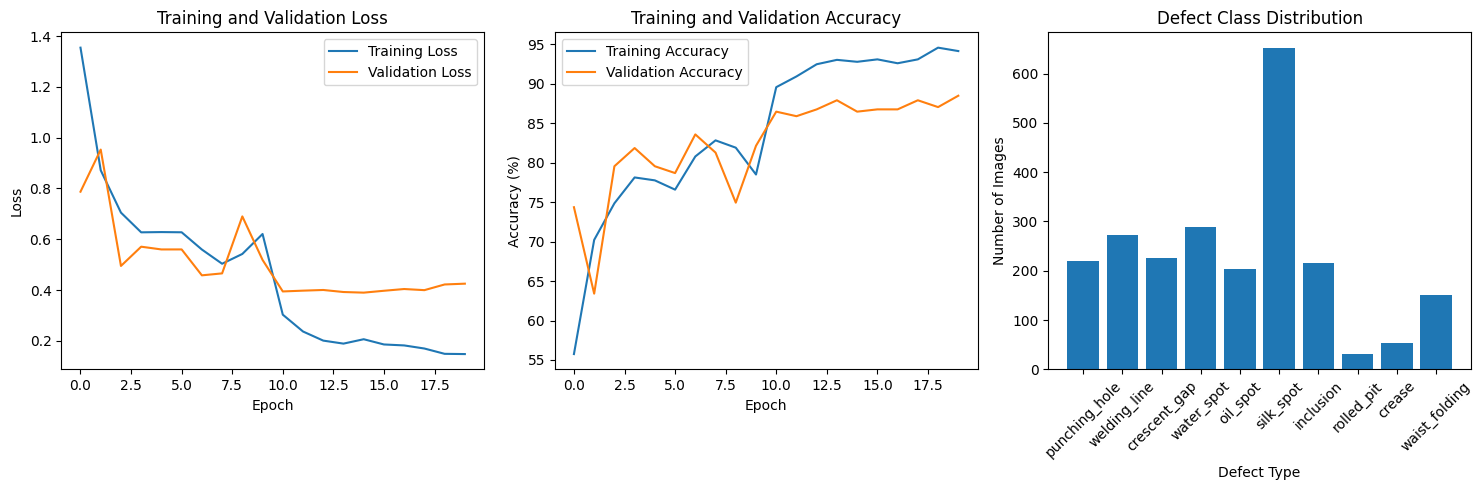

In [15]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_vit_defect_model.pth'))
test_loss, test_acc = validate_epoch(model, test_loader, criterion, device)

print(f" Final Test Results:")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plot training curves
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
# Class distribution
defect_names = list(defect_classes.values())
counts = [label_counts[name] for name in defect_names]
plt.bar(range(len(defect_names)), counts)
plt.title('Defect Class Distribution')
plt.xlabel('Defect Type')
plt.ylabel('Number of Images')
plt.xticks(range(len(defect_names)), defect_names, rotation=45)

plt.tight_layout()
plt.show()
